# Auto-generating Quantized DNN Kernels using TVM

In [1]:
import tvm
from tvm import relay
from tvm.relay import quantize
from tvm.contrib.download import download_testdata
from tvm.contrib import graph_executor

from PIL import Image
from tvm.contrib.download import download_testdata

import torch
import torchvision.models as models
from torchvision import transforms

import time
import numpy as np

## Loading a pre-trained PyTorch Model
>Get an instance of a ResNet50 model implemented in PyTorch. It's available in the torchvision package.

In [2]:
# Load pre-trained ResNet50 model
resnet50 = models.resnet50(pretrained=True)

# In evaluation mode, certain layers (like dropout) might behave differently compared to training mode. 
#This is because during evaluation, you typically want a deterministic output from the model, 
#whereas training might involve some randomness for regularization.
resnet50 = resnet50.eval()
# We grab the TorchScripted model via tracing

# A batch of one image with three channels (RGB) and a size of 224x224 pixels. 
# This is a common input size for many pre-trained image classification models.
input_shape = [1, 3, 224, 224]

# A random tensor with the specified input shape - dummy input for the model.
input_data = torch.randn(input_shape)

# Creating the TorchScript model
scripted_model = torch.jit.trace(resnet50, input_data).eval()

/home/mila/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mila/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Trying TVM on un-quantized DNN

>It's a good idea to try TVM on an un-quantized DNN first. Give TVM the network and a sample input to the network, and compile the network into a function object that can be called from Python side to produce DNN outputs.

>>The TVM how-to guides has complete tutorials on how to do this step. Pay attention to the compilation target: which hardware (CPU? GPU?) the model is being compiled for, and understand how to specify it. Compile for GPU, if you have one, or CPU otherwise.

https://tvm.apache.org/docs/how_to/compile_models/from_pytorch.html#sphx-glr-how-to-compile-models-from-pytorch-py


#### Loading a test image

In [3]:
img_url = "https://github.com/dmlc/mxnet.js/blob/main/data/cat.png?raw=true"
img_path = download_testdata(img_url, "cat.png", module="data")
img = Image.open(img_path).resize((224, 224))

# Preprocess the image and convert to tensor
my_preprocess = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
img = my_preprocess(img)
img = np.expand_dims(img, 0)

#### Converting the PyTorch model to Relay Model

_In the context of deep learning and machine learning frameworks, Relay representation refers to a specific format for representing neural network models. It's associated with the TVM (TransVision Machine) compiler framework._

_I'm converting to this model in order to  leverage TVM's capabilities for deployment and optimization on various hardware platforms_

_The output_:
* `mod`: This represents the Relay module, which is the core computational graph of the converted model.
* `params`: This is a dictionary containing the model's weights and biases as Relay tensors.

In [4]:
input_name = "input0"
shape_list = [(input_name, img.shape)]
mod, params = relay.frontend.from_pytorch(scripted_model, shape_list)

#### Compiling the Relay model using TVM

For this compilation target, I had to use my CPU. The GPUs that TVM supports are:
* Nvidia GPUs - I would set this target by using `tvm.target.cuda()` if I had a Nvidia GPU
* AMD GPUs - In this case I would set the target by using `tvm.target.rocm()`

The GPU that I have on my laptop is Intel Corporation Iris Plus Graphics G7 - this one is not supported by TVM, so this code compiles the model for CPU execution using `tvm.target.Target("llvm", host="llvm")`

In [5]:
# The compiler infrastructure I want to use for backend is going to be LLVM for CPU compilation, and that's going to be my host compiler.
target = tvm.target.Target("llvm", host="llvm")
# We are going to use the first available CPU core, and the target device will be our CPU
dev = tvm.cpu(0)

# We are creating the context for code transformations, using a high level of optimization (3)  
with tvm.transform.PassContext(opt_level=3):
    lib = relay.build(mod, target=target, params=params)

One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.


Here we are going to execute a pre-compiled Relay model using the graph_executor module in TVM.

In the context of TVM and deep learning model deployment, a Graph Module that we will be using refers to a runtime representation of a compiled Relay model.

In [6]:
dtype = "float32"
m = graph_executor.GraphModule(lib["default"](dev))
# Set inputs
m.set_input(input_name, tvm.nd.array(img.astype(dtype)))
# Execute
m.run()
# Get outputs
tvm_output = m.get_output(0)

# Measure model execution time
benchmark_unquantized = m.benchmark(dev)

This code snippet deals with image classification, using a pre-trained ResNet50 model, and compares the results between a TVM-based inference and a PyTorch-based inference for the same image.

In [7]:
synset_url = "".join(
    [
        "https://raw.githubusercontent.com/Cadene/",
        "pretrained-models.pytorch/master/data/",
        "imagenet_synsets.txt",
    ]
)
synset_name = "imagenet_synsets.txt"
synset_path = download_testdata(synset_url, synset_name, module="data")
with open(synset_path) as f:
    synsets = f.readlines()

synsets = [x.strip() for x in synsets]
splits = [line.split(" ") for line in synsets]
key_to_classname = {spl[0]: " ".join(spl[1:]) for spl in splits}

class_url = "".join(
    [
        "https://raw.githubusercontent.com/Cadene/",
        "pretrained-models.pytorch/master/data/",
        "imagenet_classes.txt",
    ]
)
class_name = "imagenet_classes.txt"
class_path = download_testdata(class_url, class_name, module="data")
with open(class_path) as f:
    class_id_to_key = f.readlines()

class_id_to_key = [x.strip() for x in class_id_to_key]

# Get top-1 result for TVM
top1_tvm = np.argmax(tvm_output.numpy()[0])
tvm_class_key = class_id_to_key[top1_tvm]

# Convert input to PyTorch variable and get PyTorch result for comparison
with torch.no_grad():
    torch_img = torch.from_numpy(img)
    output = resnet50(torch_img)

    # Get top-1 result for PyTorch
    top1_torch = np.argmax(output.numpy())
    torch_class_key = class_id_to_key[top1_torch]

print("Relay top-1 id: {}, class name: {}".format(top1_tvm, key_to_classname[tvm_class_key]))
print("Torch top-1 id: {}, class name: {}".format(top1_torch, key_to_classname[torch_class_key]))

Relay top-1 id: 282, class name: tiger cat
Torch top-1 id: 282, class name: tiger cat


## Quantizing the model to int8 precision

>Now, quantize the model down to int8 precision. TVM itself has utilities to quantize a DNN before compilation; you can find how-tos in the guides and forum. Again, you should get a function object that can be called from Python side.

>>Hint: there is a namespace tvm.relay.quantize and everything you need is somewhere in there.


In [8]:
target = tvm.target.Target("llvm", host="llvm")
dev = tvm.cpu(0)
dtype = "float32"

In [9]:
input_name = "input0"
shape_list = [(input_name, img.shape)]
mod, params = relay.frontend.from_pytorch(scripted_model, shape_list)

In [10]:
# Configuring quantization settings for converting model to 8-bit integers and applying quantization to Relay module
with relay.quantize.qconfig(calibrate_mode='global_scale',
                            dtype_input="int8",
                            dtype_weight="int8",
                            dtype_activation="int8",
                            global_scale=8.0):
    mod = relay.quantize.quantize(mod, params)

In [11]:
# Apply optimization passes for performance (opt_level=3)
with tvm.transform.PassContext(opt_level=3):
    # Build a runtime library (lib) from the quantized Relay module (mod)
    lib = relay.build(mod, target=target, params=params)

In [12]:
m = graph_executor.GraphModule(lib["default"](dev))
m.set_input(input_name, tvm.nd.array(img.astype(dtype)))

In [13]:
# Measure model execution time
benchmark_int8 = m.benchmark(dev)

## Model execution time comparison

>Use TVM's utility functions to benchmark the inference time of the quantized model vs. the un-quantized model.

>>In this task we will not try to maximize the performance of the quantized DNN, but if there is no speedup, you should try to understand it and formulate a guess.

In [14]:
benchmark_unquantized.mean

0.12238092292

In [15]:
benchmark_int8.mean

0.23729476759999998

<Figure size 1200x1600 with 0 Axes>

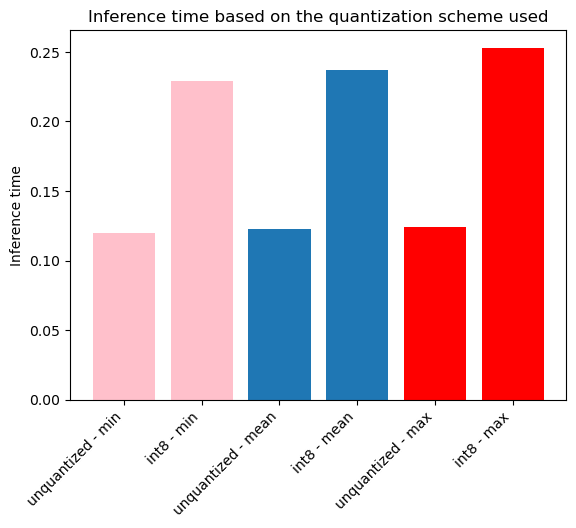

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 16))
fig, ax = plt.subplots()
ax.bar([ "unquantized - min", "int8 - min"],[benchmark_unquantized.min, benchmark_int8.min], align='center', color='pink')
ax.bar(["unquantized - mean", "int8 - mean"],[benchmark_unquantized.mean, benchmark_int8.mean])
ax.bar([ "unquantized - max", "int8 - max"],[benchmark_unquantized.max, benchmark_int8.max], align='center', color='red')
ax.set_ylabel("Inference time")
ax.set_title("Inference time based on the quantization scheme used")

plt.xticks(rotation=45, ha='right')
plt.show()

We can see that the unquantized DNN is faster in terms of inference time (when we look at all of the benchmarks - min, max, as well as mean). This is unexpected - the quantization to a smaller precision is supposed to make the DNN faster, but less accurate. 

After some research, I found out these possible reasons for this model to be slower:
* __Overhead from Quantization__: While the lower precision reduces computation for the core operations, these callibration and conversion might outweigh the gains on some hardware.
* __Hardware Acceleration Not Optimized__: If my hardware is not specifically optimized for running low-precision models, it might not be able to fully exploit the benefits of quantization.


Considering the fact that I've got this warning message when I compiled the unquantized DNN:

`One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.`

I looked a bit more into it - it wasn't intuitive at all to me that the model that's supposed to be "tuned for better performance" is still performing better compared to the model that didn't get the same message!

I researched it online, but couldn't find a specific solution that made sense. As a last resort, I decided to ask Gemini (Google's chatbot) and among other things that it mentioned, I came across this paragraph that I found interesting:

> It's possible that the lack of tuning in the unquantized model leads to a simpler execution path. Without optimizations, the model might be using a more generic implementation that, in some cases, could be surprisingly efficient for the specific hardware you're running on.

This, paired with possible overhead and hardware issues, made sense to me.

## How did TVM know that I wanted to quantize to int8?
>In your quantization setup, how did TVM know that you wanted to quantize to int8? Look into that, and vary the number of bits of quantization (the in int-$n$). Searching in forum and peeking the source code of the quantizer class will both help.

The `qconfig` function allows us to define the quantization configuration using the `QConfig` class.
This class has attributes like dtype_input and dtype_weight, which specify the number of bits and data type for different elements (input, weight) in the model.

When quantizing the DNN in my code, I specifically set the configuration so that dtype_input and dtype_weight were equal to "int8".

```
with relay.quantize.qconfig(calibrate_mode='global_scale',
                           dtype_input="int8",
                           dtype_weight="int8",
                           dtype_activation="int8",
                           global_scale=8.0):
   mod = relay.quantize.quantize(mod, params)
```

Upon taking a closer look at the source code of the `quantize` class (https://github.com/apache/tvm/blob/main/python/tvm/relay/quantize/quantize.py), I came across some more interesting discoveries.

While qconfig allows us to specify the number of bits, it also provides defaults. By default, nbit_input and nbit_weight are both set to 8, corresponding to int8. dtype_input and dtype_weight are also set to "int8" by default.

So to sum up: while we can influence the quantization type through qconfig, TVM's defaults and calibration process are geared towards using int8 for efficient low-precision inference. That's how TVM will know that we want to quantize to "int8", even if we don't specifically set the configuration to that.

>Try out int8 -> int4 -> int2 -> int1; note which precisions work. When it doesn't work, note exactly which part is failing.

In [17]:
target = tvm.target.Target("llvm", host="llvm")
dev = tvm.cpu(0)
dtype = "float32"

In [18]:
def f_quantize(q_arg):
    input_name = "input0"
    shape_list = [(input_name, img.shape)]
    mod, params = relay.frontend.from_pytorch(scripted_model, shape_list)

    # Configuring quantization settings for converting model to 8-bit integers and applying quantization to Relay module
    with relay.quantize.qconfig(calibrate_mode='global_scale',
                               dtype_input=q_arg,
                               dtype_weight=q_arg,
                               dtype_activation=q_arg,
                               global_scale=8.0):
        mod = relay.quantize.quantize(mod, params)

    with tvm.transform.PassContext(opt_level=3):
        lib = relay.build(mod, target=target, params=params)
    return lib

In [20]:
keys = ["int8", "int4", "int2", "bool"]
for key in keys:
    try:
        lib = f_quantize(key)
        m = graph_executor.GraphModule(lib["default"](dev))
        m.set_input("input0", tvm.nd.array(img.astype(dtype)))
    except Exception as e:
        print(key + " is failing!")

int4 is failing!
int2 is failing!


We can see from the output that `int4` and `int2` are failing. Before setting up the try-catch block we see here, I tried compiling them one by one and the result I received was "TVMError: unknown data type int4" (as seen below). This makes me think that they are probably not supported by the TMV compiler.  

In [21]:
f_quantize("int4")

TVMError: Traceback (most recent call last):
  30: tvm::relay::transform::FunctionPassNode::operator()(tvm::IRModule, tvm::transform::PassContext const&) const
        at /home/mila/Desktop/uiuc/tvm/src/relay/ir/transform.cc:133
  29: unpack_call<tvm::relay::Function, 3, tvm::relay::quantize::QuantizeRealizePass()::<lambda(tvm::relay::Function, tvm::IRModule, tvm::relay::transform::PassContext)> >
        at /home/mila/Desktop/uiuc/tvm/src/relay/quantize/realize.cc:553
  28: tvm::relay::ForwardRewrite(tvm::RelayExpr const&, tvm::runtime::String const&, std::function<tvm::runtime::ObjectRef (tvm::relay::Call const&)>, std::function<tvm::RelayExpr (tvm::RelayExpr const&)>)
        at /home/mila/Desktop/uiuc/tvm/src/relay/transforms/forward_rewrite.cc:177
  27: tvm::relay::ForwardRewriter::Rewrite(tvm::RelayExpr const&)
        at /home/mila/Desktop/uiuc/tvm/src/relay/transforms/forward_rewrite.cc:71
  26: tvm::relay::MixedModeMutator::VisitExpr(tvm::RelayExpr const&)
        at /home/mila/Desktop/uiuc/tvm/src/relay/ir/expr_functor.cc:102
  25: ExpandDataflow<tvm::relay::MixedModeMutator::VisitExpr(const Expr&)::<lambda(const Expr&)>, tvm::relay::MixedModeMutator::VisitExpr(const Expr&)::<lambda(const Expr&)> >
        at /home/mila/Desktop/uiuc/tvm/include/tvm/relay/expr_functor.h:509
  24: ExpandDataflow<tvm::relay::MixedModeMutator::VisitExpr(const Expr&)::<lambda(const Expr&)>, tvm::relay::MixedModeMutator::VisitExpr(const Expr&)::<lambda(const Expr&)>, tvm::relay::ExpandDataflow<tvm::relay::MixedModeMutator::VisitExpr(const Expr&)::<lambda(const Expr&)>, tvm::relay::MixedModeMutator::VisitExpr(const Expr&)::<lambda(const Expr&)> >(tvm::relay::Expr, tvm::relay::MixedModeMutator::VisitExpr(const Expr&)::<lambda(const Expr&)>, tvm::relay::MixedModeMutator::VisitExpr(const Expr&)::<lambda(const Expr&)>)::<lambda(const Expr&)> >
        at /home/mila/Desktop/uiuc/tvm/include/tvm/relay/expr_functor.h:468
  23: operator()
        at /home/mila/Desktop/uiuc/tvm/src/relay/ir/expr_functor.cc:98
  22: tvm::relay::MixedModeMutator::VisitLeaf(tvm::RelayExpr const&)
        at /home/mila/Desktop/uiuc/tvm/src/relay/ir/expr_functor.cc:81
  21: tvm::relay::MixedModeMutator::DispatchVisitExpr(tvm::RelayExpr const&)
        at /home/mila/Desktop/uiuc/tvm/src/relay/ir/expr_functor.cc:94
  20: tvm::relay::ExprMutator::VisitExpr(tvm::RelayExpr const&)
        at /home/mila/Desktop/uiuc/tvm/src/relay/ir/expr_functor.cc:158
  19: tvm::relay::ExprFunctor<tvm::RelayExpr (tvm::RelayExpr const&)>::VisitExpr(tvm::RelayExpr const&)
        at /home/mila/Desktop/uiuc/tvm/include/tvm/relay/expr_functor.h:95
  18: tvm::relay::ExprFunctor<tvm::RelayExpr (tvm::RelayExpr const&)>::InitVTable()::{lambda(tvm::runtime::ObjectRef const&, tvm::relay::ExprFunctor<tvm::RelayExpr (tvm::RelayExpr const&)>*)#5}::_FUN(tvm::runtime::ObjectRef const&, tvm::relay::ExprFunctor<tvm::RelayExpr (tvm::RelayExpr const&)>*)
        at /home/mila/Desktop/uiuc/tvm/include/tvm/relay/expr_functor.h:127
  17: tvm::relay::ExprFunctor<tvm::RelayExpr (tvm::RelayExpr const&)>::InitVTable()::{lambda(tvm::runtime::ObjectRef const&, tvm::relay::ExprFunctor<tvm::RelayExpr (tvm::RelayExpr const&)>*)#5}::operator()(tvm::runtime::ObjectRef const&, tvm::relay::ExprFunctor<tvm::RelayExpr (tvm::RelayExpr const&)>*) const
        at /home/mila/Desktop/uiuc/tvm/include/tvm/relay/expr_functor.h:127
  16: tvm::relay::ExprMutator::VisitExpr_(tvm::relay::FunctionNode const*)
        at /home/mila/Desktop/uiuc/tvm/src/relay/ir/expr_functor.cc:204
  15: tvm::relay::ExprMutator::Mutate(tvm::RelayExpr const&)
        at /home/mila/Desktop/uiuc/tvm/include/tvm/relay/expr_functor.h:190
  14: tvm::relay::MixedModeMutator::VisitExpr(tvm::RelayExpr const&)
        at /home/mila/Desktop/uiuc/tvm/src/relay/ir/expr_functor.cc:102
  13: ExpandDataflow<tvm::relay::MixedModeMutator::VisitExpr(const Expr&)::<lambda(const Expr&)>, tvm::relay::MixedModeMutator::VisitExpr(const Expr&)::<lambda(const Expr&)> >
        at /home/mila/Desktop/uiuc/tvm/include/tvm/relay/expr_functor.h:509
  12: ExpandDataflow<tvm::relay::MixedModeMutator::VisitExpr(const Expr&)::<lambda(const Expr&)>, tvm::relay::MixedModeMutator::VisitExpr(const Expr&)::<lambda(const Expr&)>, tvm::relay::ExpandDataflow<tvm::relay::MixedModeMutator::VisitExpr(const Expr&)::<lambda(const Expr&)>, tvm::relay::MixedModeMutator::VisitExpr(const Expr&)::<lambda(const Expr&)> >(tvm::relay::Expr, tvm::relay::MixedModeMutator::VisitExpr(const Expr&)::<lambda(const Expr&)>, tvm::relay::MixedModeMutator::VisitExpr(const Expr&)::<lambda(const Expr&)>)::<lambda(const Expr&)> >
        at /home/mila/Desktop/uiuc/tvm/include/tvm/relay/expr_functor.h:468
  11: operator()
        at /home/mila/Desktop/uiuc/tvm/src/relay/ir/expr_functor.cc:98
  10: tvm::relay::MixedModeMutator::VisitLeaf(tvm::RelayExpr const&)
        at /home/mila/Desktop/uiuc/tvm/src/relay/ir/expr_functor.cc:81
  9: tvm::relay::MixedModeMutator::DispatchVisitExpr(tvm::RelayExpr const&)
        at /home/mila/Desktop/uiuc/tvm/src/relay/ir/expr_functor.cc:94
  8: tvm::relay::ExprMutator::VisitExpr(tvm::RelayExpr const&)
        at /home/mila/Desktop/uiuc/tvm/src/relay/ir/expr_functor.cc:158
  7: tvm::relay::ExprFunctor<tvm::RelayExpr (tvm::RelayExpr const&)>::VisitExpr(tvm::RelayExpr const&)
        at /home/mila/Desktop/uiuc/tvm/include/tvm/relay/expr_functor.h:95
  6: tvm::relay::ExprFunctor<tvm::RelayExpr (tvm::RelayExpr const&)>::InitVTable()::{lambda(tvm::runtime::ObjectRef const&, tvm::relay::ExprFunctor<tvm::RelayExpr (tvm::RelayExpr const&)>*)#6}::_FUN(tvm::runtime::ObjectRef const&, tvm::relay::ExprFunctor<tvm::RelayExpr (tvm::RelayExpr const&)>*)
        at /home/mila/Desktop/uiuc/tvm/include/tvm/relay/expr_functor.h:128
  5: tvm::relay::ExprFunctor<tvm::RelayExpr (tvm::RelayExpr const&)>::InitVTable()::{lambda(tvm::runtime::ObjectRef const&, tvm::relay::ExprFunctor<tvm::RelayExpr (tvm::RelayExpr const&)>*)#6}::operator()(tvm::runtime::ObjectRef const&, tvm::relay::ExprFunctor<tvm::RelayExpr (tvm::RelayExpr const&)>*) const
        at /home/mila/Desktop/uiuc/tvm/include/tvm/relay/expr_functor.h:128
  4: tvm::relay::MixedModeMutator::VisitExpr_(tvm::relay::CallNode const*)
        at /home/mila/Desktop/uiuc/tvm/include/tvm/relay/expr_functor.h:291
  3: tvm::RelayExpr tvm::relay::MixedModeMutator::Rewrite<tvm::relay::CallNode>(tvm::relay::CallNode const*)
        at /home/mila/Desktop/uiuc/tvm/include/tvm/relay/expr_functor.h:313
  2: tvm::relay::ForwardRewriter::Rewrite_(tvm::relay::CallNode const*, tvm::RelayExpr const&)
        at /home/mila/Desktop/uiuc/tvm/src/relay/transforms/forward_rewrite.cc:155
  1: tvm::relay::quantize::QuantizeRealize(tvm::relay::Call const&, tvm::runtime::Array<tvm::RelayExpr, void> const&, tvm::runtime::ObjectRef const&)
        at /home/mila/Desktop/uiuc/tvm/src/relay/quantize/realize.cc:126
  0: tvm::relay::Constant tvm::relay::MakeConstantScalar<int>(tvm::runtime::DataType, int)
        at /home/mila/Desktop/uiuc/tvm/src/relay/quantize/../qnn/./op/../../op/../transforms/pattern_utils.h:290
  File "/home/mila/Desktop/uiuc/tvm/src/relay/quantize/../qnn/./op/../../op/../transforms/pattern_utils.h", line 290
TVMError: unknown data type int4